In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
def weight_init(experts,opening,method):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return -1*(closing-opening)
    elif method=='pricerel': #price relative #closing over opening
        return -1*(closing/opening)
    elif method==3: #beta
        return 1

In [71]:
def mwu(filename,lossmethod,weightmethod):
    #data is a T by N matrix with each row being the returns of each expert i at time t
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    tickers = opening.columns
    dates = opening.index.values
    #print(dates)
    #return 0
    returns = pd.DataFrame()
    for i in range(len(opening.columns)):
        tick = closing.iloc[:,i].name[:4]
        returns[tick]=closing.iloc[:,i]-opening.iloc[:,i]
    
    pricerel = pd.DataFrame()
    for i in range(len(opening.columns)):
        tick = closing.iloc[:,i].name[:4]
        pricerel[tick]=closing.iloc[:,i]/opening.iloc[:,i]
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,'equal')
    p = w/sum(w)
    
    start = 10000000
    #start_open = opening.iloc[0].values
    #return start_open
    #start_quant = []
    #for j,k in enumerate(start_open):
        #print(p[j]*start)
     #   if k == 0:
            #start_quant.append(0)
      #  elif p[j] != 0:
            #start_quant.append((p[j]*start)/k)
       # else:
        #    start_quant.append(0)
    #print(start_quant*start_open)

    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    
    for t in range(T):
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        opening_prices = opening.iloc[t].values
        opening_prices[opening.iloc[t].isnull()] = 0
        if 0 not in opening_prices:
            w[w==0] = 1
        #closing_prices_na = closing.iloc[t]
        closing_prices = closing.iloc[t].values
        closing_prices[closing.iloc[t].isnull()] = 0
        #return opening_prices
        
        #portfolio value
        if t==0: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-1]))) #new opening value
        
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                q_t.append((p[j]*values[t])/k)
            else:
                q_t.append(0)
        quantities.append(q_t)

        loss = losses(opening_prices,closing_prices,lossmethod) 
        loss[np.isnan(loss)] = 0
        M = max(abs(loss))
        loss = losses(opening_prices,closing_prices,lossmethod)/M
        loss[np.isnan(loss)] = 0
                
        #check sum of weight updates
        money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        
        if t==0 or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(1-epsilon*loss[i])
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        
       
        p = w/sum(w)
        probs.append(p)
        #return p

        

    out = pd.DataFrame(probs[1:],columns=tickers,index=dates)
    #print(out)
    out['Values'] = values
    out.to_csv(f'weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction count: ',len(transaction),'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    plt.plot(values)
    plt.show()
    return values

In [72]:
#data = pd.read_excel('lowvol_weekly.xlsx')[::-1]
filename = 'lowvol_weekly.xlsx'

Final distribution:  [0.05222073 0.05097741 0.0533131  0.05142143 0.05195254 0.05290629
 0.05244359 0.05395268 0.05443892 0.05229284 0.05135775 0.05396095
 0.05260428 0.05168751 0.05407193 0.05409282 0.05410302 0.05266199
 0.04954023]
Final transaction count:  366 total cost:  5195010.280790142
starting value:  10000000 final value:  25910654.348540958 less transaction costs:  20715644.067750815


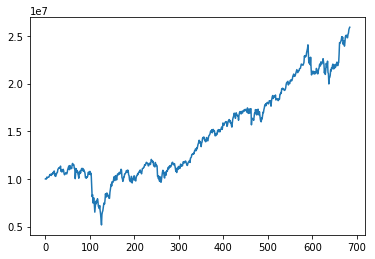

[10000000,
 9993819.247373179,
 9985706.059715955,
 10184670.693549575,
 10103409.872504357,
 10158960.749430547,
 10190086.29437434,
 10177123.99064143,
 10208383.819870865,
 10330539.303072577,
 10459330.66955639,
 10389569.216913985,
 10489529.019696007,
 10366510.51367525,
 10531041.322478885,
 10499796.482622765,
 10469558.83634649,
 10677931.754390035,
 10609546.392226472,
 10801917.026906962,
 10824743.396602733,
 10340700.654683333,
 10486211.357462002,
 10266281.409035021,
 10527344.614267105,
 10517316.39126469,
 10667908.920397859,
 10695368.790744342,
 11019378.896907113,
 11057426.098954123,
 11154548.143155264,
 11105752.43267255,
 11193980.291778727,
 11205968.262677459,
 11343367.9407472,
 10797682.684719421,
 10964470.112594176,
 10729098.156412693,
 10807718.962727265,
 10923031.402493436,
 11012410.810423678,
 10858959.520703705,
 10535207.008584034,
 10435217.69056589,
 10528790.16774356,
 10570162.181964217,
 10658478.756505657,
 10537047.582544586,
 10534265.41174

In [73]:
mwu(filename,'pricerel','equal')

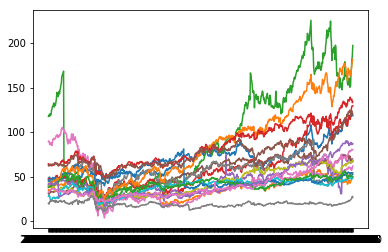

In [75]:
opening = pd.read_excel('lowvol_weekly.xlsx')[::-1].iloc[:,::2]
opening = opening.drop(['BRK.B_open'], axis=1)
plt.plot(opening)
plt.show()

In [82]:
d = (opening.iloc[-1] - opening.iloc[0])/opening.iloc[0]
d

WMT_open    1.457979
BK_open     0.377230
CI_open     0.676548
JPM_open    1.764831
DD_open     0.730868
CL_open     1.146506
HIG_open   -0.308501
AFL_open    0.180849
DOX_open    0.710112
BCE_open    0.731263
KO_open     0.182492
HON_open    3.316916
L_open      0.320655
PEP_open    1.083981
RSG_open    1.130382
PG_open     0.915419
SYY_open    1.458423
WU_open     0.341206
dtype: float64